<a href="https://colab.research.google.com/github/khpankiv/Kaggle_learning/blob/main/ell_feedback_regres_1_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**For using in Colab**

# **Setup**

In [ ]:
#A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 24.9 MB/s 
     |████████████████████████████████| 498.0 MB 11 kB/s 
     |████████████████████████████████| 1.4 MB 57.2 MB/s 
     |████████████████████████████████| 462 kB 68.1 MB/s 
     |████████████████████████████████| 5.8 MB 41.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

# **Read the datasets**

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c feedback-prize-english-language-learning
!mkdir ELL
! unzip feedback-prize-english-language-learning.zip -d ELL

Saving embedded.npy to embedded.npy
Saving kaggle.json to kaggle.json
  0% 0.00/2.80M [00:00<?, ?B/s]
100% 2.80M/2.80M [00:00<00:00, 188MB/s]
Archive:  feedback-prize-english-language-learning.zip
  inflating: ELL/sample_submission.csv  
  inflating: ELL/test.csv            
  inflating: ELL/train.csv           


In [ ]:
#test= pd.read_csv("./ELL/test.csv")
#test_sub=pd.read_csv("./ELL/sample_submission.csv")

In [ ]:
train= pd.read_csv("./ELL/train.csv")
#to make dataset smaller))
#train = train.sample(frac = 0.5)
#test = train.iloc[:,0:2]
#test_sub = train.iloc[:,[0,2]]

Data preprocessing: changing grades into integer

Change grades from [1, 1.5, 2.....4.5, 5] to [0,1,2,3,4,5...8]

And select only grades for cohesion

In [ ]:
num_text = train.shape[0]
columns = ['text_id','cohesion']
train_X = train[:].full_text.values
train_Y = (train.iloc[:,2].values)*2-2
#  uncomment for one-hot
#train_Y = tf.keras.utils.to_categorical(train_Y_n) 
#test_X = train_X
test_id = train.text_id.values
test_Y = (train.iloc[:,2].values)

Calculate the frequency of each grade to balance waightes while training

In [ ]:
distribution = train['cohesion']. value_counts(1).sort_index()
distr = dict(zip(range(9), 1/distribution.values))

In [ ]:
del train

# **Define the model**
A simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense with Softmax output and a Dropout layer.

Add BERT models

In [ ]:
tfhub_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/2"

Preprocess text data. Embed them into arrays of 256 numbers

In [ ]:
  preprocess_model = hub.KerasLayer(tfhub_preprocess)
  encoder_inputs = preprocess_model(train_X) 
  encoder = hub.KerasLayer(tfhub_encoder, trainable=False)
  outputs = encoder(encoder_inputs)
  output = outputs['pooled_output']

Save Embedded input data

In [ ]:
np.save('embedded',output)

**Load Embeddent input Data**

In [ ]:
output = np.load('embedded.npy') 

In [145]:
batch_size = 1

In [210]:
def build_classifier_model(activ,num_output):
  input = tf.keras.layers.Input(shape = (256), batch_size = batch_size)
  output = tf.keras.layers.Dense(128,activation='ReLU')(input)
  output = tf.keras.layers.Dense(64, activation='ReLU')(output) 
  output = tf.keras.layers.Dense(32, activation='ReLU')(output)
  output = tf.keras.layers.Dense(16, activation='ReLU')(output)
 # output = tf.keras.layers.Dense(9, activation='ReLU')(output)
  #net_1 = tf.keras.layers.Dropout(0.1)(output_2)
  net_1 = tf.keras.layers.Dense(num_output, activation = activ)(output)
  return tf.keras.Model(input, net_1)

In [211]:
classifier_model = build_classifier_model('linear',1)

In [212]:
classifier_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(1, 256)]                0         
                                                                 
 dense_59 (Dense)            (1, 128)                  32896     
                                                                 
 dense_60 (Dense)            (1, 64)                   8256      
                                                                 
 dense_61 (Dense)            (1, 32)                   2080      
                                                                 
 dense_62 (Dense)            (1, 16)                   528       
                                                                 
 dense_63 (Dense)            (1, 1)                    17        
                                                                 
Total params: 43,777
Trainable params: 43,777
Non-trainable

# **Model training**

In [194]:
epochs = 50

In [ ]:
   # from google3.third_party.tensorflow.core.protobuf import rewriter_config_pb2
    #    config_proto = tf.ConfigProto()
#    off = rewriter_config_pb2.RewriterConfig.OFF
 #   config_proto.graph_options.rewrite_options.arithmetic_optimization = off
  #    session = tf.Session(config=config_proto)

In [213]:
loss = tf.keras.losses.MeanSquaredError(reduction = 'auto')
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss = loss,
                         metrics = 'mse')

In [ ]:
#board = tf.keras.callbacks.TensorBoard(log_dir='./logs')

In [ ]:
#restore = tf.keras.callbacks.BackupAndRestore('/ELL')

In [91]:
output = np.array(output)

In [ ]:
history = classifier_model.fit(x = output,
                               y = train_Y,
                               epochs = epochs,
                               batch_size=batch_size, 
                               #callbacks=[restore],
                               class_weight = distr,
                               validation_split= 0.2)

Epoch 1/50
3128/3128 [==============================] - 8s 2ms/step - loss: 64.9587 - mse: 3.5903 - val_loss: 1.6416 - val_mse: 1.6416
Epoch 2/50
3128/3128 [==============================] - 8s 2ms/step - loss: 62.4103 - mse: 3.1331 - val_loss: 1.6558 - val_mse: 1.6558
Epoch 3/50
3128/3128 [==============================] - 8s 3ms/step - loss: 48.3798 - mse: 3.0779 - val_loss: 2.5023 - val_mse: 2.5023
Epoch 4/50
3128/3128 [==============================] - 7s 2ms/step - loss: 36.1687 - mse: 2.7522 - val_loss: 2.0708 - val_mse: 2.0708
Epoch 5/50
3128/3128 [==============================] - 8s 3ms/step - loss: 30.9977 - mse: 2.7416 - val_loss: 2.2962 - val_mse: 2.2962
Epoch 6/50
3128/3128 [==============================] - 8s 3ms/step - loss: 30.8605 - mse: 2.7730 - val_loss: 1.9105 - val_mse: 1.9105
Epoch 7/50
3128/3128 [==============================] - 10s 3ms/step - loss: 29.6029 - mse: 2.5188 - val_loss: 2.0032 - val_mse: 2.0032
Epoch 8/50
3128/3128 [==============================] 

In [ ]:
classifier_model.save('saved_model2')

In [ ]:
!tar -czvf model2.tar.gz saved_model1

saved_model1/
saved_model1/variables/
saved_model1/variables/variables.index
saved_model1/variables/variables.data-00000-of-00001
saved_model1/saved_model.pb
saved_model1/assets/
saved_model1/keras_metadata.pb


In [ ]:
files.download('model2.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Model evaluation**

In [206]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


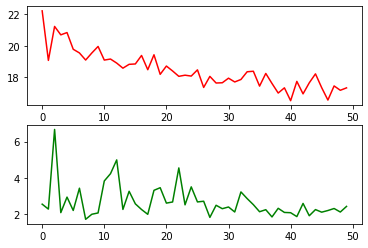

In [207]:
i = range(epochs)
plt.figure(1)
plt.title('Model evaluation')
plt.legend()

plt.subplot(2,1,1)
plt.plot(i,history_dict['loss'],'r',label = "Training loss")

#plt.subplot(2,2,2)
#plt.plot(i,history_dict['mse'],'b',label = "Training MSE")

plt.subplot(2,1,2)
plt.plot(i,history_dict['val_loss'],'g',label = "Validadion loss")

#plt.subplot(2,2,4)
#plt.plot(i,history_dict['val_mse'],'y',label = "Validation MSE")

In [ ]:
#t = test_X[0:5]

In [208]:
test_Y_n = classifier_model.predict(output,verbose = 1)

123/123 [==============================] - 0s 2ms/step


In [209]:
#for classificatio
#pred_test_Y=(np.argmax(test_Y_n,1)+2)/2
#for regression
pred_Y = np.reshape((np.round(test_Y_n)+2)/2,num_text)
mcrmse_test = np.sqrt(np.sum(np.square(pred_Y-test_Y))/num_text)
print('MCRMSE = ',mcrmse_test) 

MCRMSE =  0.7291813534213887


MCRMSE =  0.617284905504784 5 epochs

MCRMSE =  0.6333342304873718 10 epochs

MCRMSE =  0.6012389019459027 10 epochs bached 32

MCRMSE =  0.6137303634466796 5 epochs batched tuned

MCRMSE =  0.5939521873178615 5 epochs 2 dense
  
MCRMSE =  0.5827963961318415 10 epochs 5 dense

MCRMSE =  0.47713642331475004  1 epoch 3 dense shaped

regression:full +3x128+3x64

MCRMSE =  1.1748504531717312

Epoch 100/100 ====>loss: 21.0348 - mse: 2.3953



regression:full +5x128

MCRMSE =  0.6841

Epochs:300 ======> loss: 16.6 - mse: 1.99




regression:full all layers

MCRMSE =  0.568

Epochs:400 ======> loss: 6.66 - mse: 1.03


# **create output file**

In [158]:
#np.reshape(pred_Y,(num_text))
result = [test_id, pred_Y]
df_result = pd.DataFrame(np.transpose(result),columns = columns)

clear the /kaggle/working

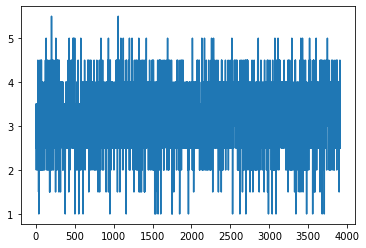

In [159]:
i = range(num_text)
plt.plot(i,df_result['cohesion'])

In [ ]:
df_result.to_csv('/kaggle/working/submission.csv')